In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scripts.afilter as afilter
import scripts.sigutil as util
import importlib
import librosa

In [29]:
importlib.reload(afilter)
importlib.reload(util)

<module 'scripts.sigutil' from 'd:\\Users\\bassa\\Desktop\\SSDP_project\\ssdp-mp1\\scripts\\sigutil.py'>

### Load voice recorded data

In [4]:
fs, _, d = util.read_normalized('data/2_RecChanging.wav')
_, _, x = util.read_normalized('data/2_Sig.wav')

In [ ]:
print("Source signal corrupted by ambient noise:")
IPython.display.Audio(d, rate=fs)

### Load music + noise data

In [2]:
fs = 8000 # Hz

cleanSig, fs1 = librosa.load('data/3_CleanGuitar.wav', sr=fs) # Downsample to fs 
noise, fs2 = librosa.load('data/talkingNoise.wav', sr=fs)

In [3]:
length = min(len(cleanSig), len(noise))
x = noise[:length]*.08
d = cleanSig[:length] + x

In [4]:
print("Signal corrupted with noise")
IPython.display.Audio(d, rate=fs)

Signal corrupted with noise


In [5]:
print("Noise")
IPython.display.Audio(x, rate=fs)

Noise


### Visualise signals

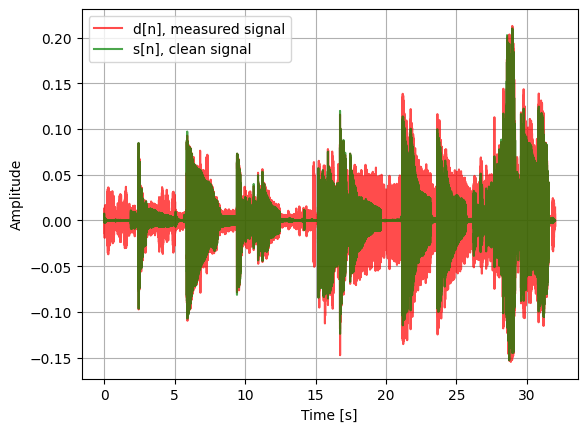

In [6]:
plt.plot(np.arange(len(d))/fs, d, color='red', label='d[n], measured signal', alpha=0.7)
#plt.plot(np.arange(len(x))/fs, x, color='blue', label='x[n], noise', alpha=0.7)
plt.plot(np.arange(len(cleanSig))/fs, cleanSig, color='green', label='s[n], clean signal', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

### Util functions

In [9]:
def plot_adaptive(i, sig):
    if (i - 2*fs) % (8*fs) == 0 and i > 10*fs:
        plt.title(f'Room impulse response at {i/fs} s')
        plt.plot(np.arange(len(sig[::-1]))/fs, sig[::-1])
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.show()

### LMS

In [ ]:
# Choose 0 < mu < 2/lambdaMax. Problem: cannot really estimate lambda_max at this stage
mu = 0.03  # choose mu intuitively

# Apply the iteration
K = 800  # number of taps
N_it = 20  # number of iterations

f_ad_lms, e_ad_lms = afilter.adaptive_filter(x, d, K, N_it, 
                                    algoType='LMS', mu=mu, callback=plot_adaptive)

In [ ]:
plt.title('Adaptive, iterative approach with LMS')
plt.plot(np.arange(len(d))/fs, d, color='blue', label='d[n]', alpha=0.7)
plt.plot(np.arange(len(e_ad_lms))/fs, e_ad_lms, color='red', label='e_ad[n]', alpha=0.7)
#plt.plot(np.arange(len(cleanSig))/fs, cleanSig, color='green', label='s[n], clean signal', alpha=0.5)
plt.grid()
plt.legend()

In [ ]:
print('Denoised signal')
IPython.display.Audio(e_ad_lms, rate=fs)

In [ ]:
print("Signal corrupted with noise")
IPython.display.Audio(d, rate=fs)

In [ ]:
print("Clean Signal")
IPython.display.Audio(cleanSig, rate=fs)

### NLMS

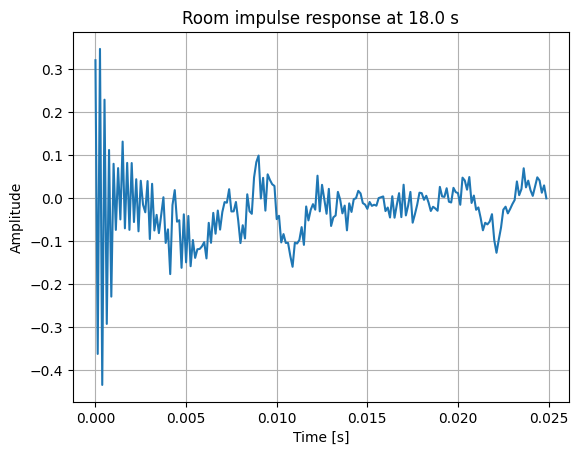

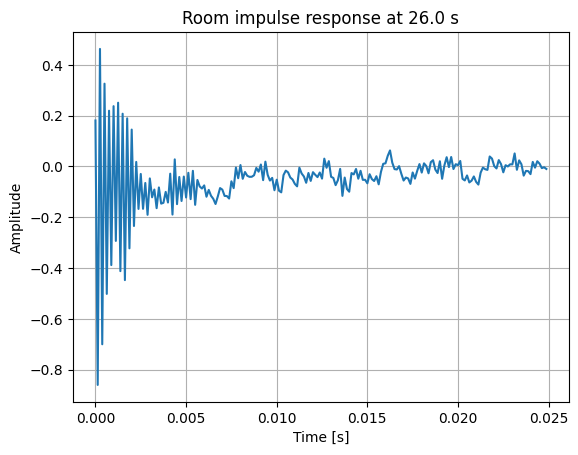

In [15]:
mu = .1  # needs to be between 0 and 2

# Apply the iteration
K = 200  # number of taps
N_it = 10  # number of iterations

f_ad_nlms, e_ad_nlms = afilter.adaptive_filter(x, d, K, N_it, 
                                    algoType='NLMS', mu=mu, callback=plot_adaptive)

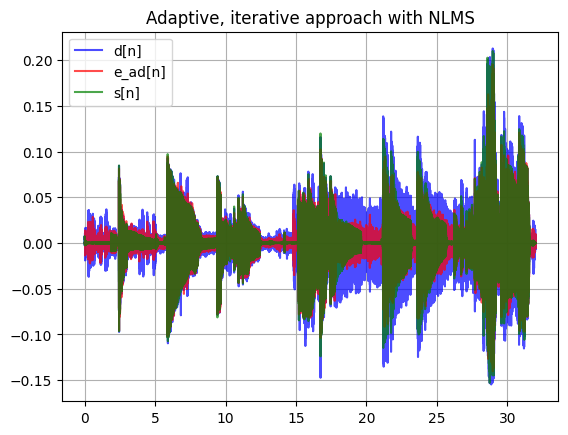

In [16]:
plt.title('Adaptive, iterative approach with NLMS')
plt.plot(np.arange(len(d))/fs, d, color='blue', label='d[n]', alpha=0.7)
plt.plot(np.arange(len(e_ad_nlms))/fs, e_ad_nlms, color='red', label='e_ad[n]', alpha=0.7)
plt.plot(np.arange(len(cleanSig))/fs, cleanSig, color='green', label='s[n]', alpha=0.7)
plt.grid()
plt.legend()

In [17]:
print('Denoised signal')
IPython.display.Audio(e_ad_nlms, rate=fs)

Denoised signal


In [18]:
print("Signal corrupted with noise")
IPython.display.Audio(d, rate=fs)

Signal corrupted with noise


In [ ]:
print("Clean Signal")
IPython.display.Audio(cleanSig, rate=fs)

### RLS

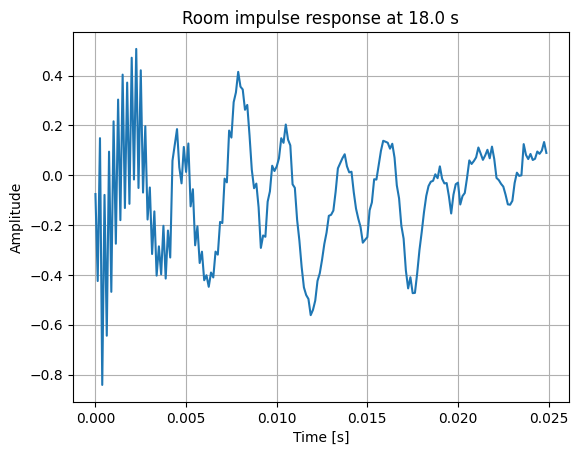

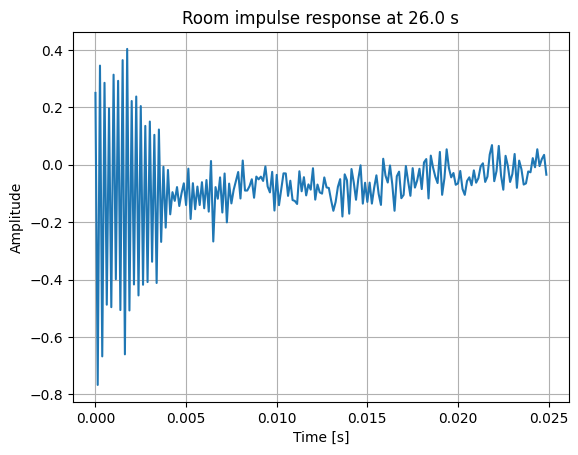

In [21]:
# Apply the iteration
delta = 0.01 # Regularization. Smaller delta => stronger filter.
lambda_ = 0.3 # Forgetting factor.

K = 200  # number of taps
N_it = 1  # number of iterations

f_ad_rls, e_ad_rls = afilter.adaptive_filter(x, d, K, N_it, 
                                            algoType='RLS', lambda_=lambda_, delta=delta, callback=plot_adaptive)

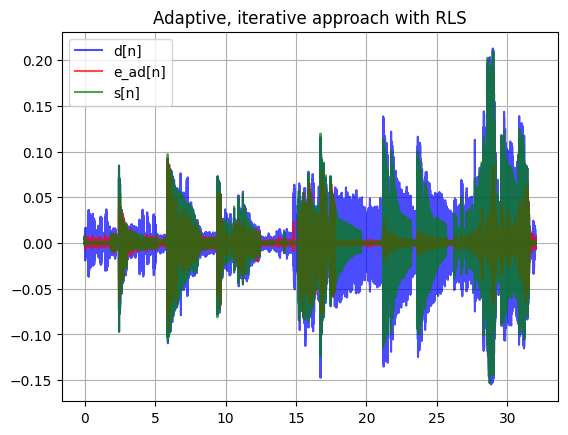

In [24]:
plt.title('Adaptive, iterative approach with RLS')
plt.plot(np.arange(len(d))/fs, d, color='blue', label='d[n]', alpha=0.7)
plt.plot(np.arange(len(e_ad_rls))/fs, e_ad_rls, color='red', label='e_ad[n]', alpha=0.7)
plt.plot(np.arange(len(cleanSig))/fs, cleanSig, color='green', label='s[n]', alpha=0.7)
plt.grid()
plt.legend()

In [23]:
print('Denoised signal')
IPython.display.Audio(e_ad_rls, rate=fs)

Denoised signal


In [33]:
print("Signal corrupted with noise")
IPython.display.Audio(d, rate=fs)

Signal corrupted with noise


### Artifical Bee Colony (ABC)

In [25]:
# TODO